# Diabetes Dataset Prediction RNN

## Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hasibur013/diabetes-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/hasibur013/diabetes-dataset/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/hasibur013/diabetes-dataset/versions/1

diabetes_dataset.csv


## Import libraries

In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Reshape, Bidirectional, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.optimizers import Adam
from tensorflow.keras.saving import load_model
from sklearn.preprocessing import StandardScaler

2024-10-22 23:35:25.508374: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 23:35:25.517538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 23:35:25.528427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 23:35:25.531878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 23:35:25.540251: I tensorflow/core/platform/cpu_feature_guar

## Load Dataset

In [4]:
diabetes_df = pd.read_csv(path + '/diabetes_dataset.csv')

In [5]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data Preparation

In [6]:
labels = diabetes_df['Outcome']
features = diabetes_df.drop(columns=['Outcome'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
features_scaler = StandardScaler()
X_train = features_scaler.fit_transform(X_train)
X_test = features_scaler.transform(X_test)
X_val = features_scaler.transform(X_val)


In [8]:
X_train.shape[1]

8

## Model

In [9]:
model = Sequential(name = 'diabetes_model')
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Reshape((1, 64), name = 'reshape_layer'))  # Reshape to (batch_size, timesteps, features)
model.add(LSTM(64, activation='relu', dropout=0.1, return_sequences=True, name = 'rnn_layer_1'))
model.add(LSTM(32, activation='relu', dropout=0.1, return_sequences=True, name = 'rnn_layer_2'))
model.add(LSTM(16, activation='relu', dropout=0.1, name = 'rnn_layer_3'))
model.add(Dense(1, activation='sigmoid', name = 'output_layer'))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729650928.430478  329701 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729650928.431002  329701 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729650928.431367  329701 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729650928.522616  329701 cuda_executor.cc:1001] could not open

Model: "diabetes_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_1 (LSTM)              │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_2 (LSTM)              │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_3 (LSTM)              │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,169 (192.07 KB)

 Trainable params: 49,169 (192.07 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val), callbacks=[ModelCheckpoint('diabetes_model.keras', monitor='val_accuracy', save_best_only=True, mode='max',)])

Epoch 1/60


I0000 00:00:1729650931.331378  329796 service.cc:146] XLA service 0x7ff734005dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729650931.331438  329796 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-10-22 23:35:31.404525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-22 23:35:31.795814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8900


 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - accuracy: 0.5625 - loss: 0.6931

I0000 00:00:1729650933.771580  329796 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.6277 - loss: 0.6919 - val_accuracy: 0.6104 - val_loss: 0.6889
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6577 - loss: 0.6851 - val_accuracy: 0.6104 - val_loss: 0.6803
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6754 - loss: 0.6669 - val_accuracy: 0.6104 - val_loss: 0.6408
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6639 - loss: 0.6071 - val_accuracy: 0.6234 - val_loss: 0.5747
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6845 - loss: 0.5672 - val_accuracy: 0.7792 - val_loss: 0.5285
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7770 - loss: 0.4924 - val_accuracy: 0.7662 - val_loss: 0.4909
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7819 - loss: 0.5119 - val_accuracy: 0.7792 - val_loss: 0.4739
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7666 - loss: 0.4744 - val_accuracy: 0.7792 - val_loss: 0.4633


## Plot model history

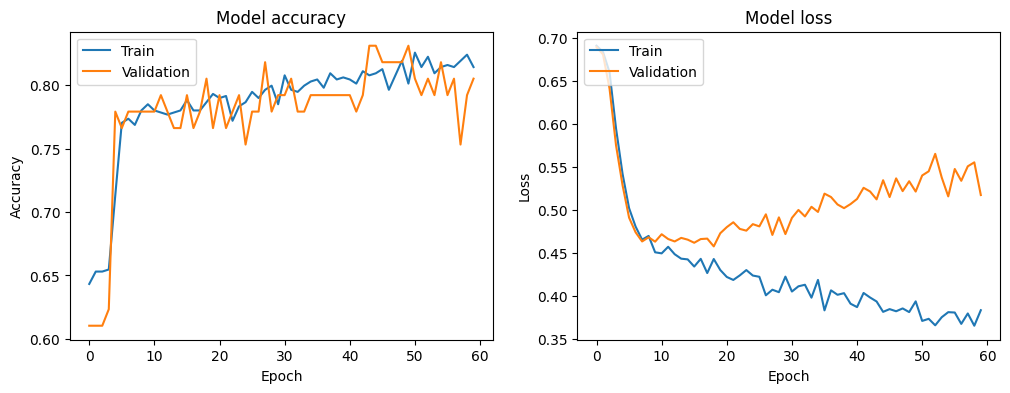

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [12]:
# Train validation data on best model
model = load_model('diabetes_model.keras')

## Good practices: Train with validation data

In [13]:
model_history = model.fit(X_val, y_val, epochs=60, batch_size=32)

Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8687 - loss: 0.4141
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8336 - loss: 0.4791
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7971 - loss: 0.5199
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8257 - loss: 0.4844
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8271 - loss: 0.4977
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8531 - loss: 0.4212 
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.4378
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8153 - loss: 0.4220
Epoch 9/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8179 - loss: 0.4278
Epoch 10/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8583 - loss: 0.4055
Epoch 11/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8323 - loss: 0.4293
Epoch 12/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8063 - loss: 0.4100
Epoch 13/60
3

## Model Evaluation

In [14]:
evaluation = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6645 - loss: 1.3294
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


In [15]:
loss, acc = evaluation
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 1.1795850992202759
Test accuracy: 0.6883116960525513


## Plotting predictions vs real label

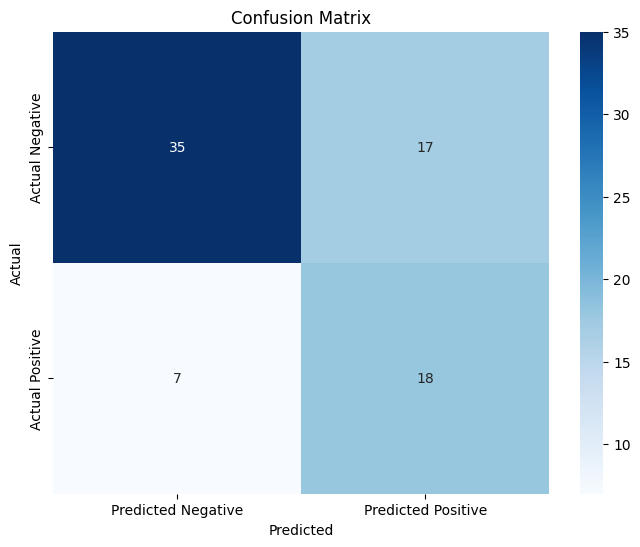

In [16]:
# Convert predictions to binary values (0 or 1) based on a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model failed predictions

In [23]:
X_test_rescaled = features_scaler.inverse_transform(X_test)
for i in range(len(y_test)):
    if y_test.iloc[i] != binary_predictions[i]:
        print(f'Actual: {y_test.iloc[i]}, Predicted: {binary_predictions[i]}')        
        print(f'Features:')
        print(f'Pregnancies: {X_test_rescaled[i][0]}')
        print(f'Glucose: {X_test_rescaled[i][1]}')
        print(f'BloodPressure: {X_test_rescaled[i][2]}')
        print(f'SkinThickness: {X_test_rescaled[i][3]}')
        print(f'Insulin: {X_test_rescaled[i][4]}')
        print(f'BMI: {X_test_rescaled[i][5]}')
        print(f'DiabetesPedigreeFunction: {X_test_rescaled[i][6]}')
        print(f'Age: {X_test_rescaled[i][7]}')
        print()

Actual: 1, Predicted: [0]
Features:
Pregnancies: 9.0
Glucose: 119.0
BloodPressure: 80.0
SkinThickness: 35.0
Insulin: 0.0
BMI: 29.0
DiabetesPedigreeFunction: 0.263
Age: 29.0

Actual: 0, Predicted: [1]
Features:
Pregnancies: 1.0
Glucose: 151.0
BloodPressure: 60.0
SkinThickness: 0.0
Insulin: 0.0
BMI: 26.1
DiabetesPedigreeFunction: 0.179
Age: 22.0

Actual: 1, Predicted: [0]
Features:
Pregnancies: 0.0
Glucose: 95.0
BloodPressure: 85.0
SkinThickness: 25.0
Insulin: 36.0
BMI: 37.4
DiabetesPedigreeFunction: 0.24700000000000003
Age: 24.0

Actual: 0, Predicted: [1]
Features:
Pregnancies: 2.0
Glucose: 175.0
BloodPressure: 88.0
SkinThickness: 0.0
Insulin: 0.0
BMI: 22.9
DiabetesPedigreeFunction: 0.326
Age: 22.0

Actual: 0, Predicted: [1]
Features:
Pregnancies: 6.0
Glucose: 129.0
BloodPressure: 90.0
SkinThickness: 7.0
Insulin: 326.0
BMI: 19.6
DiabetesPedigreeFunction: 0.582
Age: 60.0

Actual: 1, Predicted: [0]
Features:
Pregnancies: 2.0
Glucose: 134.0
BloodPressure: 70.0
SkinThickness: 0.0
Insulin: 0

## Conclusion

In this notebook, we successfully built and evaluated a Recurrent Neural Network (RNN) model to predict diabetes outcomes using a publicly available dataset. We train the RNN model. The model's performance was evaluated using various metrics, and we visualized the results to gain insights into its accuracy and areas for improvement.